<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-some-useful-pkgs" data-toc-modified-id="Import-some-useful-pkgs-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import some useful pkgs</a></span><ul class="toc-item"><li><span><a href="#Reload-my-modules" data-toc-modified-id="Reload-my-modules-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Reload my modules</a></span></li></ul></li><li><span><a href="#Some-functions" data-toc-modified-id="Some-functions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Some functions</a></span></li><li><span><a href="#Load-real-data-PSD-and-brain" data-toc-modified-id="Load-real-data-PSD-and-brain-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Load real data PSD and brain</a></span><ul class="toc-item"><li><span><a href="#PSD-and-connectome" data-toc-modified-id="PSD-and-connectome-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>PSD and connectome</a></span></li><li><span><a href="#data-for-brain-plots" data-toc-modified-id="data-for-brain-plots-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>data for brain plots</a></span></li></ul></li><li><span><a href="#Set-up-Parameters" data-toc-modified-id="Set-up-Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Set up Parameters</a></span></li><li><span><a href="#Prepare-for-SBI" data-toc-modified-id="Prepare-for-SBI-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Prepare for SBI</a></span><ul class="toc-item"><li><span><a href="#Simulator" data-toc-modified-id="Simulator-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Simulator</a></span></li><li><span><a href="#Prior" data-toc-modified-id="Prior-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Prior</a></span></li></ul></li><li><span><a href="#Results-1" data-toc-modified-id="Results-1-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Results 1</a></span><ul class="toc-item"><li><span><a href="#The-fils-saved" data-toc-modified-id="The-fils-saved-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>The fils saved</a></span></li><li><span><a href="#Get-the-posterior-samples" data-toc-modified-id="Get-the-posterior-samples-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Get the posterior samples</a></span></li><li><span><a href="#Point-estimates-of-the-parameters" data-toc-modified-id="Point-estimates-of-the-parameters-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Point estimates of the parameters</a></span></li><li><span><a href="#Spectral-and-spatial-features-estimation" data-toc-modified-id="Spectral-and-spatial-features-estimation-6.4"><span class="toc-item-num">6.4&nbsp;&nbsp;</span>Spectral and spatial features estimation</a></span></li><li><span><a href="#Corrs-for-PSD-and-spatial-features-for-each-subject" data-toc-modified-id="Corrs-for-PSD-and-spatial-features-for-each-subject-6.5"><span class="toc-item-num">6.5&nbsp;&nbsp;</span>Corrs for PSD and spatial features for each subject</a></span></li></ul></li><li><span><a href="#Results-2" data-toc-modified-id="Results-2-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Results 2</a></span><ul class="toc-item"><li><span><a href="#The-fils-saved" data-toc-modified-id="The-fils-saved-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>The fils saved</a></span></li><li><span><a href="#Get-the-posterior-samples" data-toc-modified-id="Get-the-posterior-samples-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Get the posterior samples</a></span></li><li><span><a href="#Point-estimates-of-the-parameters" data-toc-modified-id="Point-estimates-of-the-parameters-7.3"><span class="toc-item-num">7.3&nbsp;&nbsp;</span>Point estimates of the parameters</a></span></li><li><span><a href="#Spectral-and-spatial-features-estimation" data-toc-modified-id="Spectral-and-spatial-features-estimation-7.4"><span class="toc-item-num">7.4&nbsp;&nbsp;</span>Spectral and spatial features estimation</a></span></li><li><span><a href="#Corrs-for-PSD-and-spatial-features-for-each-subject" data-toc-modified-id="Corrs-for-PSD-and-spatial-features-for-each-subject-7.5"><span class="toc-item-num">7.5&nbsp;&nbsp;</span>Corrs for PSD and spatial features for each subject</a></span></li></ul></li></ul></div>

### Import some useful pkgs

In [1]:
import os
import sys
import time
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

#### Reload my modules

In [2]:
import importlib
import sgm_fns
import utils
importlib.reload(sgm_fns)
importlib.reload(utils);

In [3]:
from spectrome import Brain, path, functions
from sgm_fns import meg_psd2spatialfeature, Sgm
from utils import mag2db

In [4]:
from spectrome import Brain, path, functions
from tqdm import trange, tqdm

import torch
import torch.nn as nn 
import torch.nn.functional as F 
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn
from sklearn.preprocessing import minmax_scale

import numpy as np
import xarray as xr
from easydict import EasyDict as edict
from pathlib import Path
import pickle
import scipy

In [5]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import json

### Some functions

In [6]:
std_psd = lambda x: (x- x.mean(axis=1).reshape(-1, 1))/x.std(axis=1).reshape(-1, 1)
std_vec = lambda x: (x-x.mean())/x.std()
minmax_vec = lambda x: (x-x.min())/(x.max()-x.min())

### Load real data PSD and brain

#### PSD and connectome

In [7]:
# Load data
ind_psd_xr = xr.open_dataarray('../data/individual_psd_reordered_matlab.nc')
ind_psd = ind_psd_xr.values
freqs = ind_psd_xr["frequencies"].values
ind_conn_xr = xr.open_dataarray('../data/individual_connectomes_reordered.nc')
ind_conn = ind_conn_xr.values



data_dir = path.get_data_path()

#### data for brain plots

In [8]:
# Get reorder indeix
# dk86.***.txt is the order for the MEG data
# DK68_labelorder.xlsx is the order for the template
dk_brainnet = pd.read_excel(Path(data_dir)/"DK68_labelorder.xlsx")
with open(Path(data_dir)/'dk86atlas_regions_python.txt') as f:
    dk_python = f.readlines()
    
brainnet_order = dk_brainnet["Order in Brainstorm"]
dk_python_renamed = []
brainnet_renamed = []

for i in range(len(dk_python)):
    sp1 = dk_python[i].split('=')
    sp2 = sp1[1].split('_')
    dk_python_renamed.append((sp2[0] + ' ' + sp2[1]).lower().strip())

for i in range(len(brainnet_order)):
    brainnet_renamed.append((brainnet_order[i].replace("'","")).lower())

d = {x: a for a, x in enumerate(dk_python_renamed[0:68])}
orderedind = np.array([d[x] for x in brainnet_renamed])

In [9]:
def reorderU(wU):
    wUreorder = wU.copy()
    wUreorder = wU[orderedind]
    return wUreorder

with open(Path(data_dir)/'BNVtemplate_DK68.txt', "r") as tf:
    DKtmplateRaw = tf.readlines()
DKtmplate = np.array([int(x.strip()) for x in DKtmplateRaw])

def U2BrainVec(wU):
    emVec = np.zeros_like(DKtmplate, dtype=np.float64)
    for idx in range(1, 69):
        emVec[DKtmplate==idx] = wU[idx-1]
    return emVec

### Set up Parameters

In [11]:
paras = edict()
paras.noise_sd = 0.2
paras.num_prior_sps = int(1e5)
paras.path = Path("./main_results_nsf")

paras.robustParas = edict()
paras.robustParas.num_rep = 100
paras.robustParas.noise_sd = 0.2
paras.robustParas.num_prior_sps = int(1e5)
paras.robustParas.path = Path(paras.path/"robust_results")

paras.tuningParas = edict()
paras.tuningParas.num_rep = 100
paras.tuningParas.noise_sd = 0.2
paras.tuningParas.num_prior_sps = int(1e5)
paras.tuningParas.path = Path(paras.path/"tuning_results")

# (hidden_features, num_ts, num_bs)
paras.nsf_combos= [(50, 10, 20), (50, 10, 10), (100, 5, 10), (100, 10, 20), (50, 5, 20), (50, 20, 10)]

### Prepare for SBI

#### Simulator

In [12]:
def para2res(params):
    psd, spatialFs = sgmmodel.run_local_coupling_forward(params)
    psdDB = mag2db(np.abs(psd))
    stdPsdDB = std_psd(psdDB)
    stdSpatialF = std_vec(spatialFs.sum(axis=1))
    return stdPsdDB, stdSpatialF

def simulator(params):
    psd, sp = para2res(params)
    psd = psd[:68, :]
    res = np.concatenate([psd.flatten(), sp])
    #psdM = psd.mean(axis=0)
    #res = np.concatenate([psdM, sp])
    noise =  np.random.randn(*res.shape)*paras.noise_sd
    return res + noise

#### Prior 

In [13]:
#v_lower = 3.5-1.8
#v_upper = 3.5+1.8
#bnds = ((5.0,30.0), (5.0,200.0), (0.1,1.0), (v_lower,v_upper), (0.5,10.0), (0.5,10.0), (5.0,30.0))
#This is the order for the above bounds:  tau_e, tau_i, alpha, speed, gei, gii, tauC,

# taue, taui, tauC, speed, alpha, gii, gei
par_low = np.asarray([0.005,0.005,0.005,1.7,0.1,0.5,0.5])
par_high = np.asarray([0.03, 0.20, 0.03,5.3,  1, 10, 10])
plotLimits = np.array([par_low, par_high]).T

In [14]:
def simulator4robust(params):
    psd, sp = para2res(params)
    psd = psd[:68, :]
    res = np.concatenate([psd.flatten(), sp])
    noise =  np.random.randn(*res.shape)*paras.robustParas.noise_sd
    return res + noise

In [15]:
# obtain the brain
data_dir = path.get_data_path()
brain = Brain.Brain()
brain.add_connectome(data_dir)
brain.reorder_connectome(brain.connectome, brain.distance_matrix)
brain.bi_symmetric_c()
brain.reduce_extreme_dir()

sgmmodel = Sgm(brain.reducedConnectome, brain.distance_matrix, freqs)

In [16]:
prior = utils.BoxUniform(low=torch.as_tensor(par_low), high=torch.as_tensor(par_high))
# make a SBI-wrapper on the simulator object for compatibility
simulator_wrapper, prior = prepare_for_sbi(simulator4robust, prior)

### Results 1

#### The fils saved

In [23]:
# 0 stuck
cur_nsf_combo = paras.nsf_combos[2]
hidden_fs, num_ts, num_bs = cur_nsf_combo
cur_nsf_combo

(100, 5, 10)

In [24]:
fils = list(paras.tuningParas.path.glob(f"tuningParasDensity_{hidden_fs:.0f}_{num_ts:.0f}_{num_bs:.0f}_*.pkl"))
tmpSortFn = lambda p: int(p.stem.split("_")[-1])
sorted_fils = sorted(fils, key=tmpSortFn)

#### Get the posterior samples

In [25]:
for ixfil in tqdm(sorted_fils[:]):
    with open(ixfil, "rb") as f:
        curRes = pickle.load(f)
        
    ix = tmpSortFn(ixfil)
    #if ix != 12:
    #    continue 
    postSpss = []
    for iy in range(ind_psd.shape[-1]):
        curC = ind_conn[:, :, iy]
        curBrain = Brain.Brain()
        curBrain.add_connectome(data_dir) # grabs distance matrix
        # re-ordering for DK atlas and normalizing the connectomes:
        curBrain.reorder_connectome(curBrain.connectome, curBrain.distance_matrix)
        curBrain.connectome = curC# re-assign connectome to individual connectome
        curBrain.bi_symmetric_c()
        curBrain.reduce_extreme_dir()
        
        sp, raw_sps = meg_psd2spatialfeature(curBrain.reducedConnectome, ind_psd[:, :, iy], freqs, band="alpha")
        stdSp = std_vec(raw_sps.sum(axis=1))
        stdPsd = std_psd(mag2db(ind_psd[:, :, iy])).flatten()
        curX = torch.Tensor(np.concatenate([stdPsd, stdSp]))
        postSps = curRes.posterior.sample((10000, ), x=curX, max_sampling_batch_size=100000)
        postSpss.append(postSps)
        
    
    curRes.postSpss = postSpss
    with open(ixfil, "wb") as f:
        pickle.dump(curRes, f)

  0%|                                                                                                           | 0/5 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

 20%|███████████████████▊                                                                               | 1/5 [00:59<03:56, 59.16s/it]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

                        prior support. It may take a long time to collect the
                        remaining 9909 samples. Consider interrupting
                        (Ctrl-C) and switching to `sample_with='mcmc'`.


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

 40%|███████████████████████████████████████▌                                                           | 2/5 [02:55<04:38, 92.78s/it]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

 60%|███████████████████████████████████████████████████████████▍                                       | 3/5 [03:54<02:34, 77.28s/it]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 4/5 [05:24<01:22, 82.40s/it]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [06:04<00:00, 72.90s/it]


#### Point estimates of the parameters

In [26]:
estParass = []
for ixfil in tqdm(sorted_fils[:]):
    with open(ixfil, "rb") as f:
        curRes = pickle.load(f)
    estParass.append(np.array([np.median(postSps.numpy(), axis=0) for postSps in curRes.postSpss]))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.44it/s]


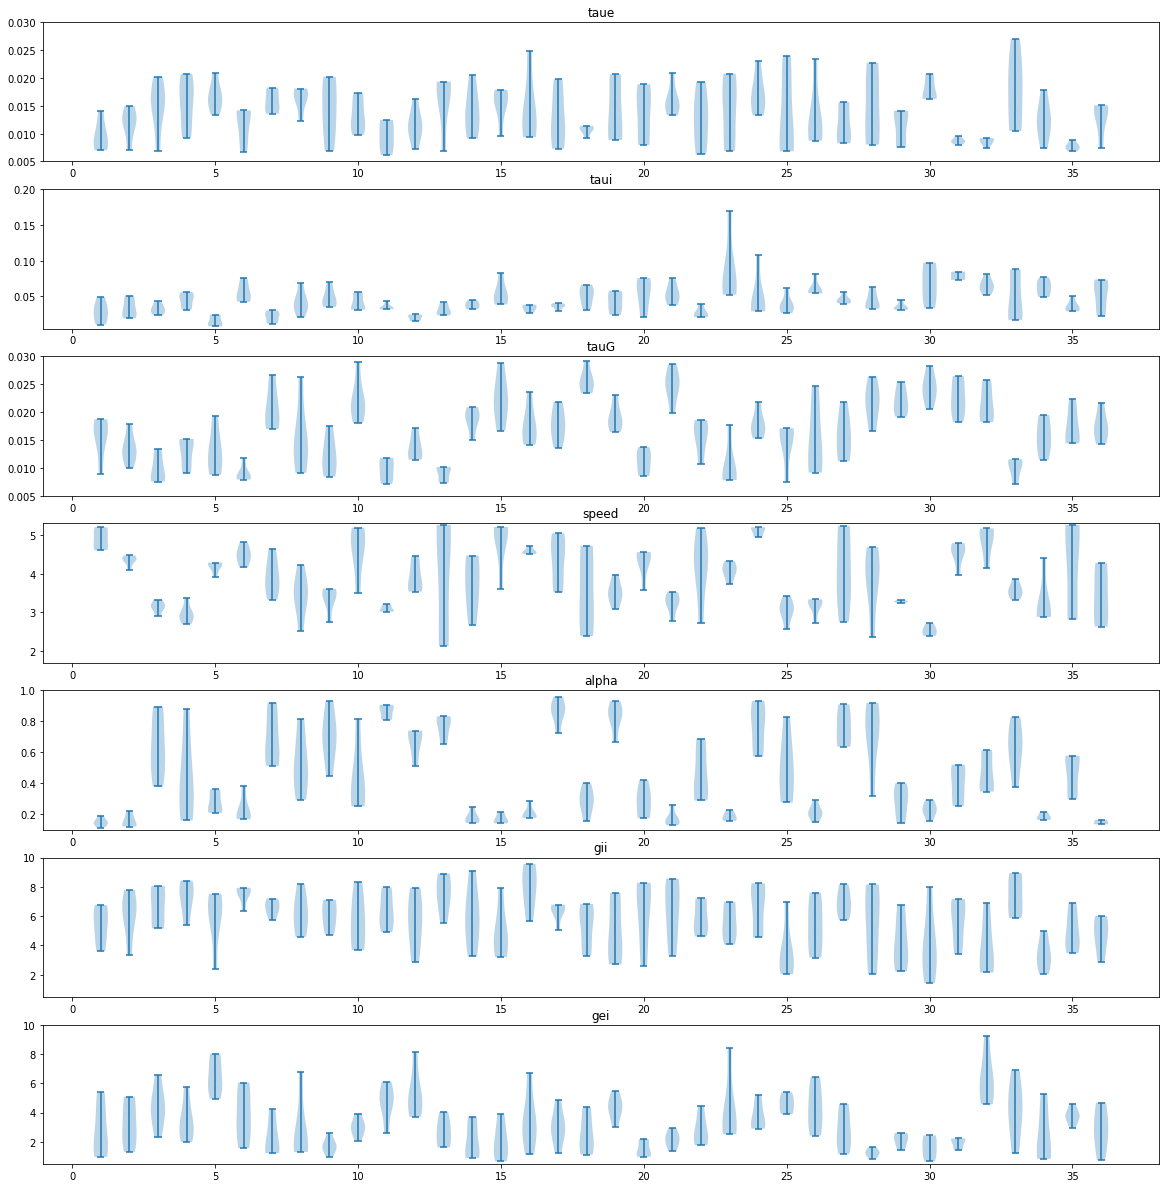

In [27]:
plotLimits = np.array([par_low, par_high]).T
labels=['taue','taui','tauG','speed','alpha','gii','gei']
estParass = np.array(estParass)
plt.figure(figsize=[20, 21])
for ix in range(7):
    plt.subplot(7, 1, ix+1)
    plt.violinplot(estParass[:, :, ix])
    plt.ylim(plotLimits[ix, :])
    plt.title(labels[ix])

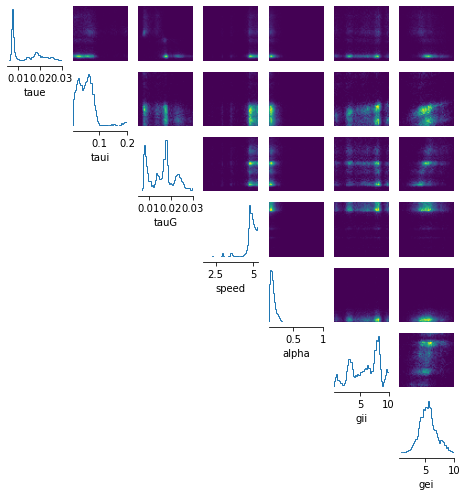

In [28]:
# taue, taui, tauC, speed, alpha, gii, gei
_ = analysis.pairplot(curRes.postSpss[0], limits=plotLimits, labels=['taue','taui','tauG','speed','alpha','gii','gei'], figsize=(8,8))

#### Spectral and spatial features estimation

In [29]:
# the estimated spatial feature from MEG
MEGSPs = []
MEGSPRaws = []
for ix in trange(36):
    curC = ind_conn[:, :, ix]
    curBrain = Brain.Brain()
    curBrain.add_connectome(data_dir) # grabs distance matrix
    # re-ordering for DK atlas and normalizing the connectomes:
    curBrain.reorder_connectome(curBrain.connectome, curBrain.distance_matrix)
    curBrain.connectome = curC# re-assign connectome to individual connectome
    curBrain.bi_symmetric_c()
    curBrain.reduce_extreme_dir()
    
    curMEGSP, curMEGSPRaw = meg_psd2spatialfeature(curBrain.reducedConnectome, ind_psd[:, :, ix], freqs)
    MEGSPs.append(curMEGSP)
    MEGSPRaws.append(curMEGSPRaw.sum(axis=1))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 50.85it/s]


In [30]:
# the estimated PSD and spatial feature from SGM 
# for each iteration, we have 20 in total 
for ixfil in tqdm(sorted_fils[:]):
    sgmPSDs = []
    sgmSPs = []
    with open(ixfil, "rb") as f:
        curRes = pickle.load(f)
        
    curEstParas = np.array([np.median(i.numpy(), axis=0) for i in curRes.postSpss])
    for ix in trange(36):
        curParas = curEstParas[ix, :]
        curC = ind_conn[:, :, ix]
        curBrain = Brain.Brain()
        curBrain.add_connectome(data_dir) # grabs distance matrix
        # re-ordering for DK atlas and normalizing the connectomes:
        curBrain.reorder_connectome(curBrain.connectome, curBrain.distance_matrix)
        curBrain.connectome = curC# re-assign connectome to individual connectome
        curBrain.bi_symmetric_c()
        curBrain.reduce_extreme_dir()
        
        curSgmModel = Sgm(curBrain.reducedConnectome, curBrain.distance_matrix, freqs)
        curPSD, curSPs = curSgmModel.run_local_coupling_forward(curParas)
        curPSD = curPSD[:68, :]
        curPSD = std_psd(mag2db(np.abs(curPSD)))
        
        sgmPSDs.append(curPSD)
        sgmSPs.append(curSPs.sum(axis=1))
    
    
    
    curRes.sgmPSDs = sgmPSDs
    curRes.sgmSPs = sgmSPs
    with open(ixfil, "wb") as f:
        pickle.dump(curRes, f)

  0%|                                                                                                           | 0/5 [00:00<?, ?it/s]

  0%|                                                                                                          | 0/36 [00:00<?, ?it/s]

  3%|██▋                                                                                               | 1/36 [00:01<00:37,  1.07s/it]

  6%|█████▍                                                                                            | 2/36 [00:02<00:36,  1.08s/it]

  8%|████████▏                                                                                         | 3/36 [00:03<00:36,  1.10s/it]

 11%|██████████▉                                                                                       | 4/36 [00:04<00:35,  1.11s/it]

 14%|█████████████▌                                                                                    | 5/36 [00:05<00:34,  1.11s/it]

 17%|████████████████▎                          

 60%|███████████████████████████████████████████████████████████▍                                       | 3/5 [02:01<01:21, 40.66s/it]

  0%|                                                                                                          | 0/36 [00:00<?, ?it/s]

  3%|██▋                                                                                               | 1/36 [00:01<00:36,  1.04s/it]

  6%|█████▍                                                                                            | 2/36 [00:02<00:36,  1.07s/it]

  8%|████████▏                                                                                         | 3/36 [00:03<00:36,  1.10s/it]

 11%|██████████▉                                                                                       | 4/36 [00:04<00:35,  1.11s/it]

 14%|█████████████▌                                                                                    | 5/36 [00:05<00:34,  1.11s/it]

 17%|████████████████▎                          

In [31]:
corrs = []
PSDs = []
MEGPSDMean = np.mean([std_psd(mag2db(ind_psd[:, :, ix])).mean(axis=0) for ix in range(36)], axis=0)
for ix in trange(len(sorted_fils)):
    with open(sorted_fils[ix], "rb") as f:
        curRes = pickle.load(f)
    curPSD = np.array(curRes.sgmPSDs).mean(axis=1).mean(axis=0)
    cor = scipy.stats.pearsonr(std_vec(MEGPSDMean), std_vec(curPSD))[0]
    corrs.append(cor)
    PSDs.append(curPSD)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.69it/s]


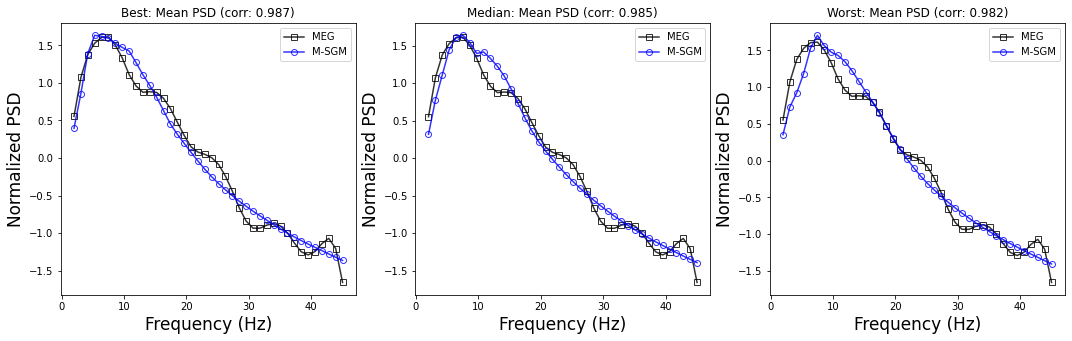

In [32]:
corrs = np.array(corrs)
bestId = np.argmax(corrs)
worstId = np.argmin(corrs)
medId = np.argmin(np.abs(corrs-np.median(corrs)))
titles = ["Best", "Median", "Worst"]
plt.figure(figsize=[18, 5])
for ix, curId in enumerate([bestId, medId, worstId]):
    plt.subplot(1, 3, ix+1)
    plt.title(f"{titles[ix]}: Mean PSD (corr: {corrs[curId]:.3f})")
    plt.plot(freqs, std_vec(MEGPSDMean), linestyle = '-',marker = 's',fillstyle = 'none',color = 'k', label = "MEG", alpha = 0.8)
    plt.plot(freqs, std_vec(PSDs[curId]), linestyle = '-',marker = 'o',fillstyle = 'none',color = 'b', label = "M-SGM", alpha = 0.8)
    plt.xlabel('Frequency (Hz)', fontsize = 17)
    plt.legend()
    plt.ylabel('Normalized PSD', fontsize = 17)

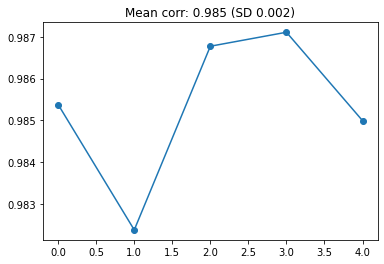

In [33]:
plt.title(f"Mean corr: {corrs.mean():.3f} (SD {corrs.std():.3f})")
plt.plot(corrs, "o-")

#### Corrs for PSD and spatial features for each subject

In [34]:
MEG_psd_each_ROIs = np.array([std_psd(mag2db(ind_psd[:, :, ix])) for ix in range(36)])
PSDCorrss = []

for ix in trange(len(sorted_fils)):
    with open(sorted_fils[ix], "rb") as f:
        curRes = pickle.load(f)
    curSGM_psd_ROIs = np.array(curRes.sgmPSDs)
    PSDCorrs = []
    for iy in range(MEG_psd_each_ROIs.shape[0]):
        curMEG = MEG_psd_each_ROIs[iy]
        curSGM = curSGM_psd_ROIs[iy]
        #PSDCorrs.append(scipy.stats.pearsonr(curMEG, curSGM)[0])
        PSDCorrs.append(np.mean([scipy.stats.pearsonr(curMEG[iz], curSGM[iz])[0] for iz in range(68)]))
    PSDCorrss.append(PSDCorrs)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.48it/s]


In [35]:
np.sort(np.array(PSDCorrss).mean(axis=1))

array([0.84397347, 0.84510855, 0.84535659, 0.85286354, 0.86785563])

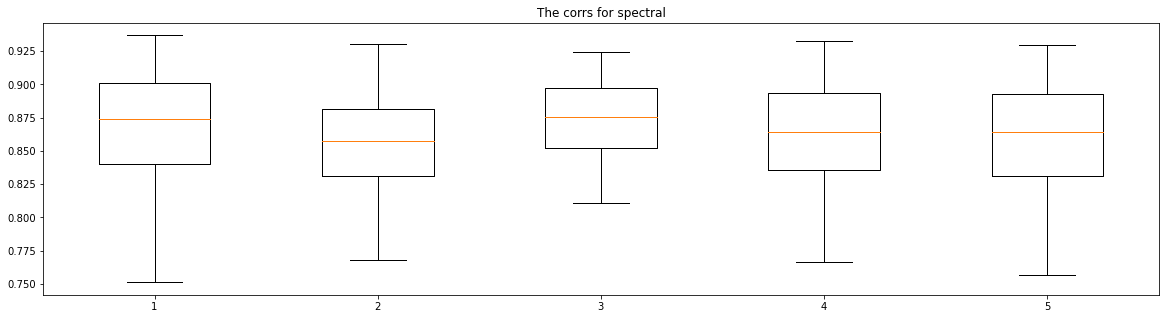

In [36]:
plt.figure(figsize=[20, 5])
plt.title("The corrs for spectral")
_ = plt.boxplot(np.array(PSDCorrss).T, showfliers=False)

In [37]:
SPCorrss = []
for ix in trange(len(sorted_fils)):
    with open(sorted_fils[ix], "rb") as f:
        curRes = pickle.load(f)
    SPCorrs = []
    for mv, ov in zip(curRes.sgmSPs, MEGSPs):
        SPCorrs.append(np.dot(mv/np.linalg.norm(mv), ov))
        #SPCorrs.append(scipy.stats.pearsonr(mv, ov)[0])
    SPCorrss.append(np.array(SPCorrs))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 32.33it/s]


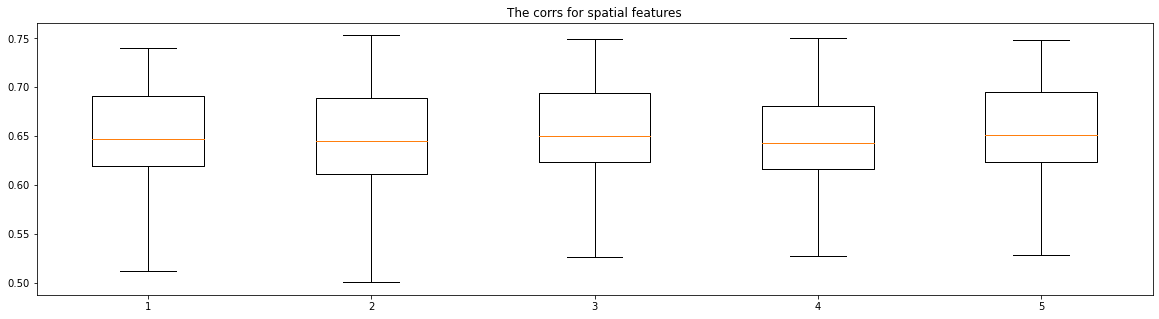

In [38]:
plt.figure(figsize=[20, 5])
plt.title("The corrs for spatial features")
_ = plt.boxplot(np.array(SPCorrss).T, showfliers=False)

### Results 2

#### The fils saved

In [39]:
# 0 stuck
cur_nsf_combo = paras.nsf_combos[4]
hidden_fs, num_ts, num_bs = cur_nsf_combo
cur_nsf_combo

(50, 5, 20)

In [40]:
fils = list(paras.tuningParas.path.glob(f"tuningParasDensity_{hidden_fs:.0f}_{num_ts:.0f}_{num_bs:.0f}_*.pkl"))
tmpSortFn = lambda p: int(p.stem.split("_")[-1])
sorted_fils = sorted(fils, key=tmpSortFn)

#### Get the posterior samples

In [41]:
for ixfil in tqdm(sorted_fils[:]):
    with open(ixfil, "rb") as f:
        curRes = pickle.load(f)
        
    ix = tmpSortFn(ixfil)
    #if ix != 12:
    #    continue 
    postSpss = []
    for iy in range(ind_psd.shape[-1]):
        curC = ind_conn[:, :, iy]
        curBrain = Brain.Brain()
        curBrain.add_connectome(data_dir) # grabs distance matrix
        # re-ordering for DK atlas and normalizing the connectomes:
        curBrain.reorder_connectome(curBrain.connectome, curBrain.distance_matrix)
        curBrain.connectome = curC# re-assign connectome to individual connectome
        curBrain.bi_symmetric_c()
        curBrain.reduce_extreme_dir()
        
        sp, raw_sps = meg_psd2spatialfeature(curBrain.reducedConnectome, ind_psd[:, :, iy], freqs, band="alpha")
        stdSp = std_vec(raw_sps.sum(axis=1))
        stdPsd = std_psd(mag2db(ind_psd[:, :, iy])).flatten()
        curX = torch.Tensor(np.concatenate([stdPsd, stdSp]))
        postSps = curRes.posterior.sample((10000, ), x=curX, max_sampling_batch_size=100000)
        postSpss.append(postSps)
        
    
    curRes.postSpss = postSpss
    with open(ixfil, "wb") as f:
        pickle.dump(curRes, f)

  0%|                                                                                                           | 0/5 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

 20%|███████████████████▊                                                                               | 1/5 [00:24<01:38, 24.64s/it]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

 40%|███████████████████████████████████████▌                                                           | 2/5 [01:01<01:35, 31.92s/it]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

                        prior support. It may take a long time to collect the
                        remaining 9981 samples. Consider interrupting
                        (Ctrl-C) and switching to `sample_with='mcmc'`.


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

 60%|██████████████████████████████████████████████████████████▊                                       | 3/5 [05:41<04:50, 145.36s/it]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 4/5 [05:56<01:33, 93.81s/it]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [06:30<00:00, 78.10s/it]


#### Point estimates of the parameters

In [42]:
estParass = []
for ixfil in tqdm(sorted_fils[:]):
    with open(ixfil, "rb") as f:
        curRes = pickle.load(f)
    estParass.append(np.array([np.median(postSps.numpy(), axis=0) for postSps in curRes.postSpss]))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.32it/s]


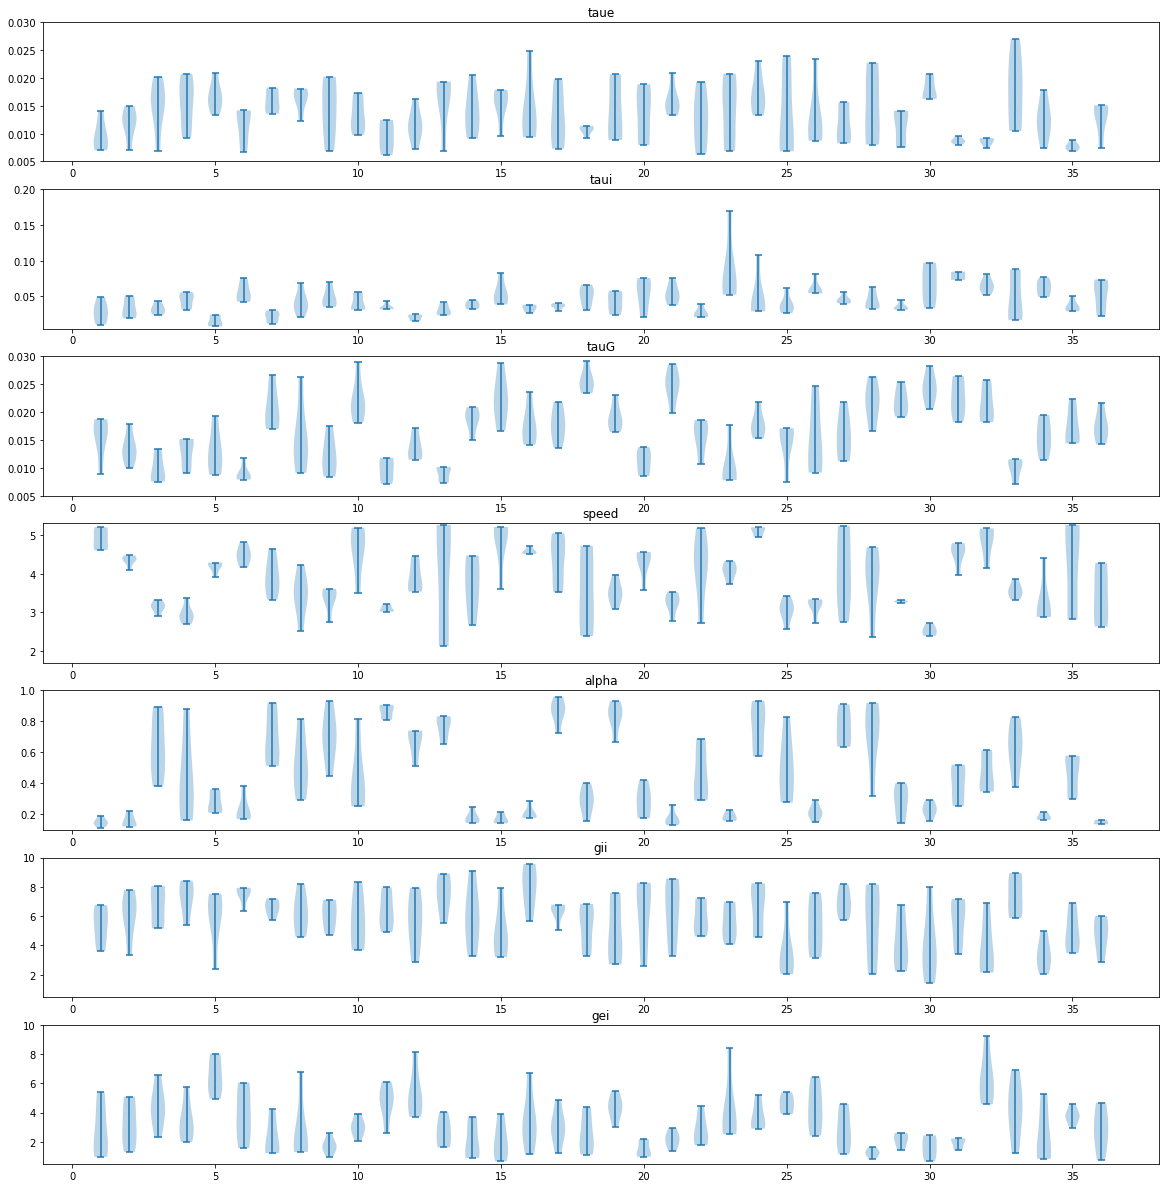

In [27]:
plotLimits = np.array([par_low, par_high]).T
labels=['taue','taui','tauG','speed','alpha','gii','gei']
estParass = np.array(estParass)
plt.figure(figsize=[20, 21])
for ix in range(7):
    plt.subplot(7, 1, ix+1)
    plt.violinplot(estParass[:, :, ix])
    plt.ylim(plotLimits[ix, :])
    plt.title(labels[ix])

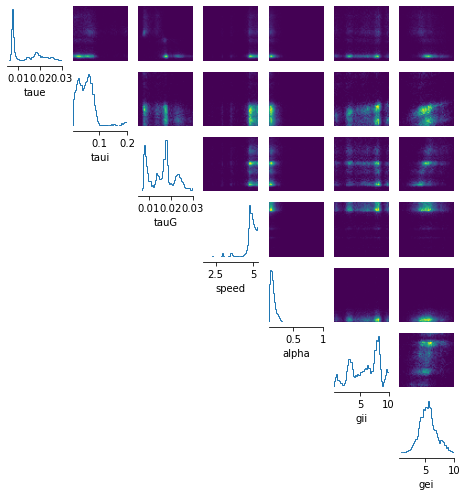

In [28]:
# taue, taui, tauC, speed, alpha, gii, gei
_ = analysis.pairplot(curRes.postSpss[0], limits=plotLimits, labels=['taue','taui','tauG','speed','alpha','gii','gei'], figsize=(8,8))

#### Spectral and spatial features estimation

In [43]:
# the estimated spatial feature from MEG
MEGSPs = []
MEGSPRaws = []
for ix in trange(36):
    curC = ind_conn[:, :, ix]
    curBrain = Brain.Brain()
    curBrain.add_connectome(data_dir) # grabs distance matrix
    # re-ordering for DK atlas and normalizing the connectomes:
    curBrain.reorder_connectome(curBrain.connectome, curBrain.distance_matrix)
    curBrain.connectome = curC# re-assign connectome to individual connectome
    curBrain.bi_symmetric_c()
    curBrain.reduce_extreme_dir()
    
    curMEGSP, curMEGSPRaw = meg_psd2spatialfeature(curBrain.reducedConnectome, ind_psd[:, :, ix], freqs)
    MEGSPs.append(curMEGSP)
    MEGSPRaws.append(curMEGSPRaw.sum(axis=1))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 46.47it/s]


In [44]:
# the estimated PSD and spatial feature from SGM 
# for each iteration, we have 20 in total 
for ixfil in tqdm(sorted_fils[:]):
    sgmPSDs = []
    sgmSPs = []
    with open(ixfil, "rb") as f:
        curRes = pickle.load(f)
        
    curEstParas = np.array([np.median(i.numpy(), axis=0) for i in curRes.postSpss])
    for ix in trange(36):
        curParas = curEstParas[ix, :]
        curC = ind_conn[:, :, ix]
        curBrain = Brain.Brain()
        curBrain.add_connectome(data_dir) # grabs distance matrix
        # re-ordering for DK atlas and normalizing the connectomes:
        curBrain.reorder_connectome(curBrain.connectome, curBrain.distance_matrix)
        curBrain.connectome = curC# re-assign connectome to individual connectome
        curBrain.bi_symmetric_c()
        curBrain.reduce_extreme_dir()
        
        curSgmModel = Sgm(curBrain.reducedConnectome, curBrain.distance_matrix, freqs)
        curPSD, curSPs = curSgmModel.run_local_coupling_forward(curParas)
        curPSD = curPSD[:68, :]
        curPSD = std_psd(mag2db(np.abs(curPSD)))
        
        sgmPSDs.append(curPSD)
        sgmSPs.append(curSPs.sum(axis=1))
    
    
    
    curRes.sgmPSDs = sgmPSDs
    curRes.sgmSPs = sgmSPs
    with open(ixfil, "wb") as f:
        pickle.dump(curRes, f)

  0%|                                                                                                           | 0/5 [00:00<?, ?it/s]

  0%|                                                                                                          | 0/36 [00:00<?, ?it/s]

  3%|██▋                                                                                               | 1/36 [00:01<00:37,  1.08s/it]

  6%|█████▍                                                                                            | 2/36 [00:02<00:39,  1.17s/it]

  8%|████████▏                                                                                         | 3/36 [00:03<00:40,  1.23s/it]

 11%|██████████▉                                                                                       | 4/36 [00:04<00:39,  1.25s/it]

 14%|█████████████▌                                                                                    | 5/36 [00:06<00:38,  1.23s/it]

 17%|████████████████▎                          

 60%|███████████████████████████████████████████████████████████▍                                       | 3/5 [02:10<01:27, 43.69s/it]

  0%|                                                                                                          | 0/36 [00:00<?, ?it/s]

  3%|██▋                                                                                               | 1/36 [00:01<00:36,  1.05s/it]

  6%|█████▍                                                                                            | 2/36 [00:02<00:40,  1.20s/it]

  8%|████████▏                                                                                         | 3/36 [00:03<00:41,  1.25s/it]

 11%|██████████▉                                                                                       | 4/36 [00:04<00:39,  1.22s/it]

 14%|█████████████▌                                                                                    | 5/36 [00:06<00:37,  1.20s/it]

 17%|████████████████▎                          

In [45]:
corrs = []
PSDs = []
MEGPSDMean = np.mean([std_psd(mag2db(ind_psd[:, :, ix])).mean(axis=0) for ix in range(36)], axis=0)
for ix in trange(len(sorted_fils)):
    with open(sorted_fils[ix], "rb") as f:
        curRes = pickle.load(f)
    curPSD = np.array(curRes.sgmPSDs).mean(axis=1).mean(axis=0)
    cor = scipy.stats.pearsonr(std_vec(MEGPSDMean), std_vec(curPSD))[0]
    corrs.append(cor)
    PSDs.append(curPSD)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.38it/s]


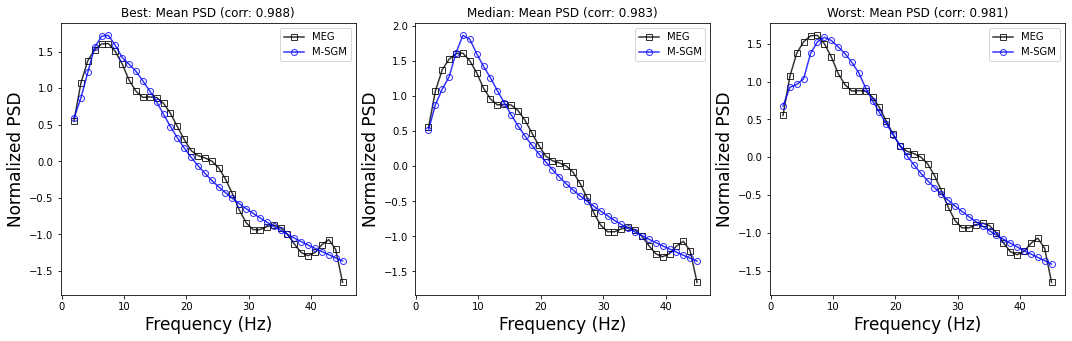

In [46]:
corrs = np.array(corrs)
bestId = np.argmax(corrs)
worstId = np.argmin(corrs)
medId = np.argmin(np.abs(corrs-np.median(corrs)))
titles = ["Best", "Median", "Worst"]
plt.figure(figsize=[18, 5])
for ix, curId in enumerate([bestId, medId, worstId]):
    plt.subplot(1, 3, ix+1)
    plt.title(f"{titles[ix]}: Mean PSD (corr: {corrs[curId]:.3f})")
    plt.plot(freqs, std_vec(MEGPSDMean), linestyle = '-',marker = 's',fillstyle = 'none',color = 'k', label = "MEG", alpha = 0.8)
    plt.plot(freqs, std_vec(PSDs[curId]), linestyle = '-',marker = 'o',fillstyle = 'none',color = 'b', label = "M-SGM", alpha = 0.8)
    plt.xlabel('Frequency (Hz)', fontsize = 17)
    plt.legend()
    plt.ylabel('Normalized PSD', fontsize = 17)

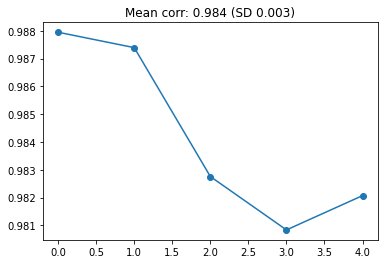

In [47]:
plt.title(f"Mean corr: {corrs.mean():.3f} (SD {corrs.std():.3f})")
plt.plot(corrs, "o-")

#### Corrs for PSD and spatial features for each subject

In [48]:
MEG_psd_each_ROIs = np.array([std_psd(mag2db(ind_psd[:, :, ix])) for ix in range(36)])
PSDCorrss = []

for ix in trange(len(sorted_fils)):
    with open(sorted_fils[ix], "rb") as f:
        curRes = pickle.load(f)
    curSGM_psd_ROIs = np.array(curRes.sgmPSDs)
    PSDCorrs = []
    for iy in range(MEG_psd_each_ROIs.shape[0]):
        curMEG = MEG_psd_each_ROIs[iy]
        curSGM = curSGM_psd_ROIs[iy]
        #PSDCorrs.append(scipy.stats.pearsonr(curMEG, curSGM)[0])
        PSDCorrs.append(np.mean([scipy.stats.pearsonr(curMEG[iz], curSGM[iz])[0] for iz in range(68)]))
    PSDCorrss.append(PSDCorrs)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


In [49]:
np.sort(np.array(PSDCorrss).mean(axis=1))

array([0.84383519, 0.84574205, 0.8494722 , 0.85506027, 0.86495103])

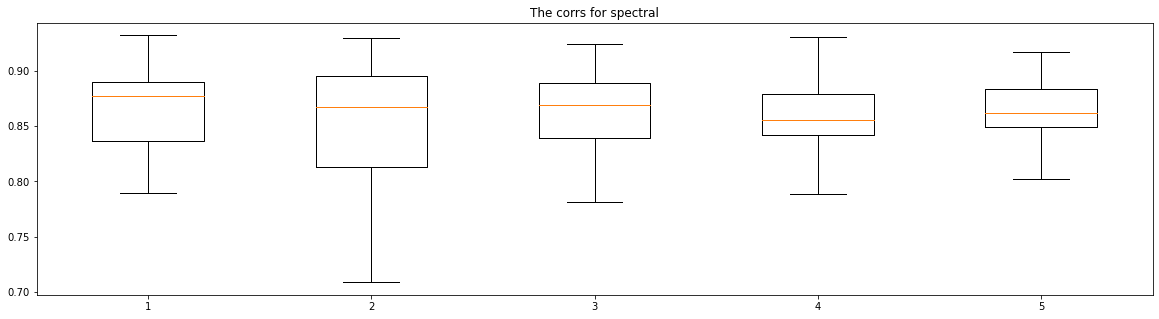

In [50]:
plt.figure(figsize=[20, 5])
plt.title("The corrs for spectral")
_ = plt.boxplot(np.array(PSDCorrss).T, showfliers=False)

In [37]:
SPCorrss = []
for ix in trange(len(sorted_fils)):
    with open(sorted_fils[ix], "rb") as f:
        curRes = pickle.load(f)
    SPCorrs = []
    for mv, ov in zip(curRes.sgmSPs, MEGSPs):
        SPCorrs.append(np.dot(mv/np.linalg.norm(mv), ov))
        #SPCorrs.append(scipy.stats.pearsonr(mv, ov)[0])
    SPCorrss.append(np.array(SPCorrs))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 32.33it/s]


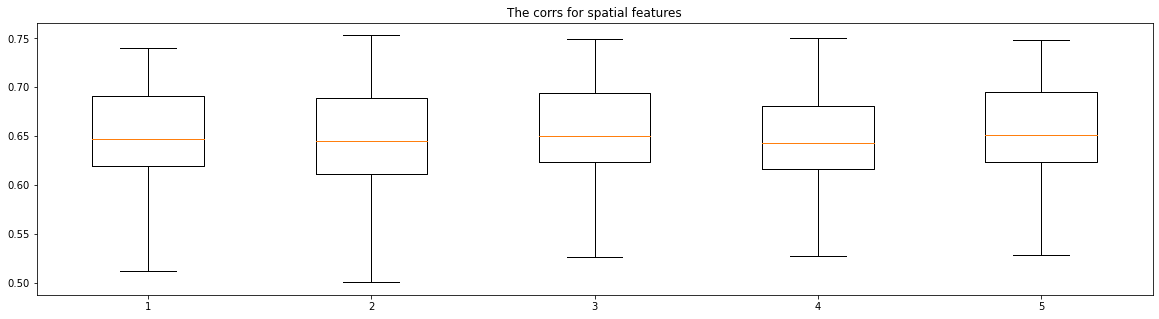

In [38]:
plt.figure(figsize=[20, 5])
plt.title("The corrs for spatial features")
_ = plt.boxplot(np.array(SPCorrss).T, showfliers=False)